# Case6 : One dimensional density associated with simple coalescent process

In this notebook, we estimate density associated with simple coalescent process on one-dimensional tree space by log-concave MLE. 

In [1]:
# importing packages
import lcdtreespace as lcd
import pandas as pd
import numpy as np
from importlib.resources import files
import os
import matplotlib.pyplot as plt

## sample data

We estimate following density on one-dimensional tree space:
$$f(x) =
\begin{cases}
    -\frac{1}{6}\exp(-x-1) + \frac{1}{2}\exp(-x + 1 - 2\max(0,1-x)) & \text{if } x \text{ is in the orthant 1} \\
    \frac{1}{3}\exp(-x-1) & \text{otherwise}..
\end{cases}$$
where $x$ in the right equation corresponds to the coordinate of a point $x$. This density is the distribution of a gene tree generated by a simple coalescent process of $3$-tree (The species tree has internal edge of length 1).

Package lcdtreespace has sample data drawn from this density at ```files("lcdtreespace").joinpath("data", "case6")```. 

The file "testcase_{$n$}\_{$i$}\_X.npy" contain sample coordinates with sample size $n$. "testcase_{$n$}_{$i$}_ort.npy" contains the orthants that each point belongs to.

Here, we compute the log-concave MLE from "testcase_200_0" files.

In [2]:
# list of sample data available
np.sort(os.listdir(files("lcdtreespace").joinpath("data", "case6")))[:10]

array(['testcase_1000_0_X.npy', 'testcase_1000_0_ort.npy',
       'testcase_1000_1_X.npy', 'testcase_1000_1_ort.npy',
       'testcase_1000_2_X.npy', 'testcase_1000_2_ort.npy',
       'testcase_1000_3_X.npy', 'testcase_1000_3_ort.npy',
       'testcase_1000_4_X.npy', 'testcase_1000_4_ort.npy'], dtype='<U23')

In [3]:
# load data
x = np.load(files("lcdtreespace").joinpath("data", "case6", "testcase_200_0_x.npy"))
ort = np.load(files("lcdtreespace").joinpath("data", "case6", "testcase_200_0_ort.npy"))
x[:10], ort[:10]
# x contains coordinates, while ort contains the orthant each point belongs to

(array([0.14712608, 0.15221612, 0.15388442, 0.15406326, 0.22340238,
        0.27969304, 0.28490724, 0.30302409, 0.35015445, 0.38217977]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Computation of log-concave MLE

The computation of one dimensional log-concave MLE can be done by ```lcd.lcmle_1dim``` function. 

In [4]:
# optimization with BFGS is fast but unstable, thus we conduct 10 runs and adopt the best result
opt_y = lcd.lcmle_1dim(x=x,ort = ort,n_ort = 3, print_objective=True,bend=True,runs=10)

run 0: 3.075181959728188
run 1: 3.0533529550811567
run 2: 3.055855094107744
run 3: 3.0863894113478643
run 4: 3.0661750734108355
run 5: 3.0491766503608897
run 6: 3.0729095677091394
run 7: 3.04815468985044
run 8: 3.046688371079159
run 9: 3.066288271234113


In [5]:
# density object
lcmle = lcd.logconcave_density_estimate_1dim(opt_y, x, ort, 3, bend=True) # log-concave MLE
true_density = lcd.coalescent_1dim(T=1) # true density

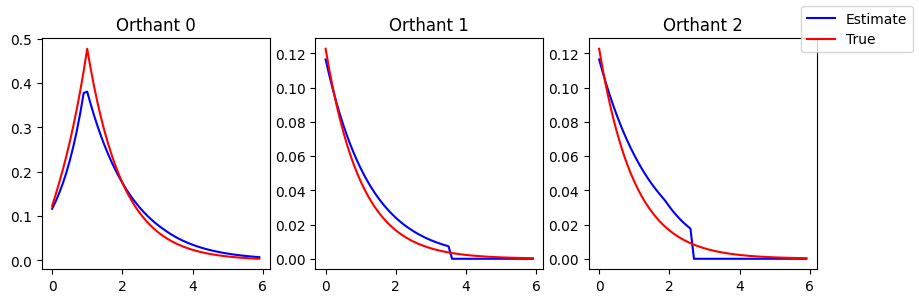

In [6]:
# plot of estimated density and true density
fig, axes = plt.subplots(1,3,figsize=(10,3))
xx = np.arange(0,6,0.1)
axes[0].plot(xx, np.vectorize(lcmle.pdf)(xx,0), c = "blue")
axes[0].plot(xx, np.vectorize(true_density.pdf)(xx,0), c = "red")
axes[0].set_title("Orthant 0")
axes[1].plot(xx, np.vectorize(lcmle.pdf)(xx,1), c = "blue")
axes[1].plot(xx, np.vectorize(true_density.pdf)(xx,1), c = "red")
axes[1].set_title("Orthant 1")
axes[2].plot(xx, np.vectorize(lcmle.pdf)(xx,2), c = "blue", label = "Estimate")
axes[2].plot(xx, np.vectorize(true_density.pdf)(xx,2), c = "red", label = "True")
axes[2].set_title("Orthant 2")
fig.legend()

## Kernel density estimator
To compare the result, we also compute the kernel density estimator from the same sample.

In [7]:
kde = lcd.kernel_density_estimate_1dim(x, ort, 3)

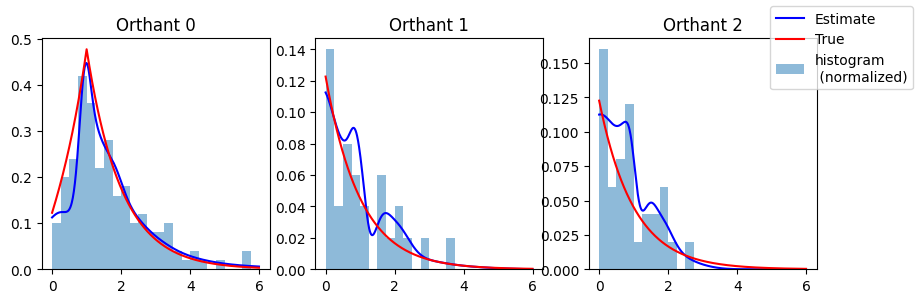

In [8]:
# plot of kernel density estimate and true_density
# Kernel density estimator
bin_edges = [k for k in np.arange(0,6.1,1/4)]
fig, axes = plt.subplots(1,3,figsize=(10,3))
xx = np.arange(0,6,0.01)
axes[0].plot(xx, np.vectorize(kde.pdf)(xx,0), c = "blue")
axes[0].plot(xx, np.vectorize(true_density.pdf)(xx,0), c = "red")
axes[0].hist(x[ort==0], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==0])) ] , alpha=0.5)
axes[0].set_title("Orthant 0")
axes[1].plot(xx, np.vectorize(kde.pdf)(xx,1), c = "blue")
axes[1].plot(xx, np.vectorize(true_density.pdf)(xx,1), c = "red")
axes[1].hist(x[ort==1], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==1])) ] , alpha=0.5)
axes[1].set_title("Orthant 1")
axes[2].plot(xx, np.vectorize(kde.pdf)(xx,2), c = "blue", label = "Estimate")
axes[2].plot(xx, np.vectorize(true_density.pdf)(xx,2), c = "red", label = "True")
axes[2].hist(x[ort==2], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==2])) ] , alpha=0.5, label="histogram\n (normalized)")
axes[2].set_title("Orthant 2")
fig.legend()

## Computation of Integrated Squared Error (ISE)

In [9]:
# calculation of integrted squared error
lcmle_ise, lcmle_err = lcd.ise_1dim(true_density, lcmle, epsabs = 1e-5)
kde_ise, kde_err = lcd.ise_1dim(true_density, kde, epsabs = 1e-5)

In [10]:
lcmle_ise, kde_ise

(0.004935921395397494, 0.010934521505402169)